# FTP/kg and hills...in Pittsburgh or otherwise
Lots of formulae from [here](https://ridefar.info/wp-content/uploads/pdf/method.pdf), estimate of rolling resistance for my tires from [here](https://www.bicyclerollingresistance.com/road-bike-reviews/mavic-yksion-elite-2018#rr), air resistance numbers from first link plus [here](https://ridefar.info/bike/cycling-speed/air-resistance-cyclist/).

In [67]:
# imports
from scipy.constants import g, R, atm
import numpy as np
from itertools import product
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [68]:
# define basic functions

# air density in kg/m^3
def air_density(altitude=500, T=293):
    L = 0.0065
    T0 = 298
    M = 0.02896
    Rs = 287.058
    p_exp = M*g/(R*L)
    p = atm*(1-(L*altitude/T0))**p_exp
    return p/(Rs*T)

# resisting force from air
def F_air(mph, CdA, rho=air_density()):
    speed = mph/2.237
    return 0.5 * CdA * rho * speed**2

# rolling resistance, default value is coefficient for my tires
# gradient in absolute, not percent (i.e. 5% is 0.05) because I'm not a heathen
def F_roll(grad, m, Crr):
    return Crr * np.cos(np.arctan(grad)) * m * g

# gravitational resistance
def F_grav(grad, m):
    return np.sin(np.arctan(grad)) * m * g

# power needed for a given speed up a given gradient etc.
# L_dt is drivetrain loss, default number from ridefar
def P_needed(mph, grad, m, CdA, Crr, rho, L_dt=0.051):
    speed = mph/2.237 # convert to m/s
    F_resist = F_air(mph, CdA, rho) + F_roll(grad, m, Crr) + F_grav(grad, m)
    return F_resist * speed / (1.0-L_dt)

# calculate power per body mass
def Wperkg(body_mass, bike_mass, mph, grad, CdA=0.45, Crr=0.00483, rho=air_density()):
    W = P_needed(mph, grad, body_mass+bike_mass, CdA, Crr, rho)
    return W / body_mass

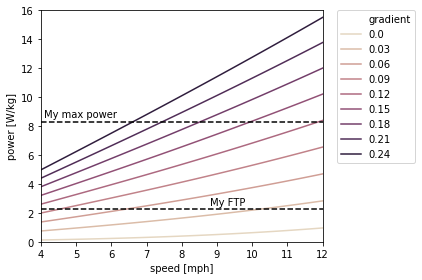

In [162]:
mph_vals = np.arange(4,12.1,0.1)
grad_vals = np.arange(0.0, 0.25, 0.03)
df = pd.DataFrame.from_records(data=[p for p in product(mph_vals, grad_vals)], columns=["speed", "gradient"])
# calculate for me and my bike
df['W/kg'] = [Wperkg(63.5, 8.0, a.speed, a.gradient) for a in df.itertuples()]

sns.lineplot(x='speed', y='W/kg', data=df, hue='gradient', 
             palette=sns.cubehelix_palette(len(grad_vals), start=0, rot=.5))
plt.plot([4,12],[2.24,2.24],'--k')
plt.text(8.8, 2.5, "My FTP")
plt.plot([4,12],[8.27,8.27],'--k')
plt.text(4.1, 8.6, "My max power")
plt.xlim([4,12])
plt.ylim([0.0,16])
plt.xlabel("speed [mph]")
plt.ylabel("power [W/kg]")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("power_vs_speed.png", dpi=300)

In [70]:
# figure out max speed at FTP (or set percentage of it) as a function of gradient
# need to solve a cubic in the speed to do this...
def calc_speed(watts_per_kg, grad, body_mass, bike_mass, CdA=0.45, Crr=0.00483, rho=air_density(), L_dt=0.051):
    total_mass = body_mass + bike_mass
    a3 = 0.5*CdA*rho
    a1 = F_roll(grad, total_mass, Crr) + F_grav(grad, total_mass)
    a0 = -1.0 * watts_per_kg*body_mass * (1.0-L_dt)
    rts = np.roots([a3, 0, a1, a0])
    # one should be real, return that one
    return [r.real*2.237 for r in rts if r.imag==0][0]

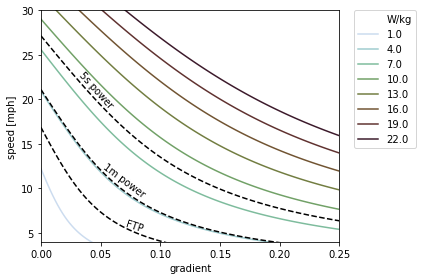

In [167]:
P_vals = np.arange(1.0,22.1,3.0)
grad_vals = np.arange(0.0,0.252,0.002)
df = pd.DataFrame.from_records(data=[p for p in product(P_vals, grad_vals)], columns=["W/kg", "gradient"])
df['mph'] = [calc_speed(a[1], a.gradient, 63.5, 8.0) for a in df.itertuples()]

sns.lineplot(x='gradient', y='mph', data=df, hue='W/kg', 
             palette=sns.cubehelix_palette(len(P_vals), start=0.2, rot=1.0))

plt.plot(grad_vals, [calc_speed(2.24, grad, 63.5, 8.0) for grad in grad_vals], '--k')
plt.text(0.07, 5.1, "FTP", rotation=-18)
plt.plot(grad_vals, [calc_speed(8.27, grad, 63.5, 8.0) for grad in grad_vals], '--k')
plt.text(0.03, 19, "5s power", rotation=-48)
plt.plot(grad_vals, [calc_speed(4.1, grad, 63.5, 8.0) for grad in grad_vals], '--k')
plt.text(0.05, 9, "1m power", rotation=-37)
plt.xlim([0,0.25])
plt.ylim([4,30.0])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("speed [mph]")
plt.tight_layout()
plt.savefig("speed_vs_gradient.png", dpi=300)